In [1]:
import os
import pyspark
import pandas as pd
import torch
import torch.nn.functional as functional
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import warnings

from pathlib import Path

from transformers import AutoTokenizer, AutoModel, AutoConfig

from pytorch_lightning.loggers import TensorBoardLogger

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T

from functools import partial
from ptls.nn import TrxEncoder, RnnSeqEncoder
from ptls.nn.trx_encoder.encoders import IdentityEncoder
from ptls.frames.coles import CoLESModule
from ptls.preprocessing import PandasDataPreprocessor
from ptls.data_load.datasets import MemoryMapDataset
from ptls.frames.coles import ColesDataset
from ptls.frames.coles.split_strategy import SampleSlices
from ptls.frames import PtlsDataModule
from ptls.data_load.utils import collate_feature_dict
from ptls.frames.inference_module import InferenceModule
from ptls.data_load.iterable_processing import ISeqLenLimit, FeatureFilter

from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import RocCurveDisplay
from lightgbm import LGBMClassifier

In [2]:
warnings.filterwarnings('ignore')
data_path = Path('data')
pl.seed_everything(42)
plt.style.use('bmh')
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

Global seed set to 42


In [3]:
def _td_gender(df, col_event_time):
    df = df.withColumn('_et_day', F.substring(F.lpad(F.col(col_event_time), 15, '0'), 1, 6).cast('float'))

    df = df.withColumn('_et_time', F.substring(F.lpad(F.col(col_event_time), 15, '0'), 8, 8))
    df = df.withColumn('_et_time', F.regexp_replace('_et_time', r'\:60$', ':59'))
    df = df.withColumn('_et_time', F.unix_timestamp('_et_time', 'HH:mm:ss') / (24 * 60 * 60))

    df = df.withColumn('event_time', F.col('_et_day') + F.col('_et_time'))
    df = df.drop('_et_day', '_et_time')
    return df

def embed_mcc_descs(mcc_descriptions):
    tokenizer = AutoTokenizer.from_pretrained('cointegrated/rubert-tiny2')
    bert = AutoModel.from_config(AutoConfig.from_pretrained('cointegrated/rubert-tiny2')).cuda()

    tokens = tokenizer(mcc_descriptions, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        out = bert(**{k: v.to(bert.device) for k, v in tokens.items()})
    
    embeddings = functional.normalize(out.last_hidden_state[:, 0, :]).cpu()

    return dict(zip(mcc_descriptions, embeddings))

In [4]:
spark_conf = pyspark.SparkConf()
spark_conf.setMaster("local[*]").setAppName("PysparkDataPreprocessor")
spark_conf.set("spark.driver.maxResultSize", "4g")
spark_conf.set("spark.executor.memory", "16g")
spark_conf.set("spark.executor.memoryOverhead", "4g")
spark_conf.set("spark.driver.memory", "16g")
spark_conf.set("spark.driver.memoryOverhead", "4g")
spark_conf.set("spark.cores.max", "24")
spark_conf.set("spark.sql.shuffle.partitions", "200")
spark_conf.set("spark.local.dir", "../../spark_local_dir")


spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
spark.sparkContext.getConf().getAll()

transactions = spark.read.options(header=True, inferSchema=True).csv(str(data_path / 'transactions.csv'))
mcc_codes = spark.read.options(header=True, inferSchema=True).csv(str(data_path / 'tr_mcc_codes.csv'), sep=';')
joined = transactions.join(mcc_codes, on='mcc_code', how='inner').drop('mcc_code')
joined = _td_gender(joined, 'tr_datetime').toPandas().drop(columns=['tr_datetime'])
spark.stop()

embs = embed_mcc_descs(joined['mcc_description'].unique().tolist())
joined['mcc_description'] = joined['mcc_description'].apply(lambda description: embs[description])

preprocessor = PandasDataPreprocessor(
    col_id='customer_id',
    col_event_time='event_time',
    event_time_transformation='none',
    cols_category=['tr_type', 'term_id'],
    cols_numerical=['amount'],
    cols_identity=['mcc_description']
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/22 21:11:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/03/22 21:11:34 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [5]:
dataset = MemoryMapDataset(
    data=preprocessor.fit_transform(joined),
    i_filters=[
        ISeqLenLimit(max_seq_len=2000),
        FeatureFilter(keep_feature_names='customer_id')
    ]
)

In [6]:
TRAIN_SIZE = int(len(dataset) * 0.8)
VAL_SIZE = len(dataset) - TRAIN_SIZE

train, val = torch.utils.data.random_split(dataset, [TRAIN_SIZE, VAL_SIZE])

In [7]:
trx_encoder_params = dict(
    embeddings_noise=0.003,
    numeric_values={'amount': 'identity'},
    embeddings={
        'tr_type': {'in': 100, 'out': 24},
    },
    custom_embeddings = {'mcc_description': IdentityEncoder(312)},
    norm_embeddings=False
)

seq_encoder = RnnSeqEncoder(
    trx_encoder=TrxEncoder(**trx_encoder_params),
    hidden_size=1024,
    type='gru',
    bidir=False,
    trainable_starter='static'
)

model = CoLESModule(
    seq_encoder=seq_encoder,
    optimizer_partial=partial(torch.optim.Adam, lr=0.002, weight_decay=0.0),
    lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=10, gamma=0.9025),
)

In [8]:
train_dl = PtlsDataModule(
    train_data=ColesDataset(
        train,
        splitter=SampleSlices(
            split_count=5,
            cnt_min=15,
            cnt_max=75,
        ),
    ),
    train_num_workers=8,
    train_batch_size=128,
    valid_data=ColesDataset(
        val,
        splitter=SampleSlices(
            split_count=5,
            cnt_min=25,
            cnt_max=100
        )
    ),
    valid_batch_size=512,
    valid_num_workers=16
)

In [9]:
trainer = pl.Trainer(
    max_epochs=150,
    gpus=[0] if torch.cuda.is_available() else 0,
    enable_progress_bar=False,
    logger=TensorBoardLogger('lightning_logs', name='exogenous_text_embeddings_random')
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [10]:
%%time
trainer.fit(model, train_dl)
print(trainer.logged_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name               | Type            | Params
-------------------------------------------------------
0 | _loss              | ContrastiveLoss | 0     
1 | _seq_encoder       | RnnSeqEncoder   | 4.2 M 
2 | _validation_metric | BatchRecallTopK | 0     
3 | _head              | Head            | 0     
-------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.765    Total estimated model params size (MB)
2023-03-22 21:14:02.312115: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 21:14:02.459589: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. 

{'loss': tensor(115.8684), 'seq_len': tensor(42.0125), 'recall_top_k': tensor(0.7863)}
CPU times: user 18min 53s, sys: 35min 2s, total: 53min 55s
Wall time: 52min 26s


### Using embeddings for downstream task

In [11]:
train_dl = torch.utils.data.DataLoader(
    dataset=train,
    collate_fn=collate_feature_dict,
    shuffle=False,
    batch_size=512,
    num_workers=4
)

val_dl = torch.utils.data.DataLoader(
    dataset=val,
    collate_fn=collate_feature_dict,
    shuffle=False,
    batch_size=512,
    num_workers=4
)

In [12]:
inf_model = InferenceModule(
    seq_encoder
)

In [13]:
df_train = pd.concat(trainer.predict(inf_model, train_dl))
df_val = pd.concat(trainer.predict(inf_model, val_dl))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


In [14]:
target_df = pd.read_csv(data_path / 'gender_train.csv')

In [15]:
df_train = df_train.merge(target_df, how='left', on='customer_id').dropna()
df_val = df_val.merge(target_df, how='left', on='customer_id').dropna()

In [16]:
X_train = df_train.drop(columns=['gender'])
y_train = df_train['gender']
X_val = df_val.drop(columns=['gender'])
y_val = df_val['gender']
scaler = MaxAbsScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [17]:
model = LGBMClassifier(
    n_estimators=500,
    boosting_type='gbdt',
    objective='binary',
    metric='auc',
    subsample=0.5,
    subsample_freq=1,
    learning_rate=0.02,
    feature_fraction=0.75,
    max_depth=6,
    lambda_l1=1,
    lambda_l2=1,
    min_data_in_leaf=50,
    random_state=42,
    n_jobs=8
)

In [ ]:
model = model.fit(X_train, y_train, 
    eval_set=(X_val, y_val),
    eval_metric=['roc_auc', 'accuracy'])

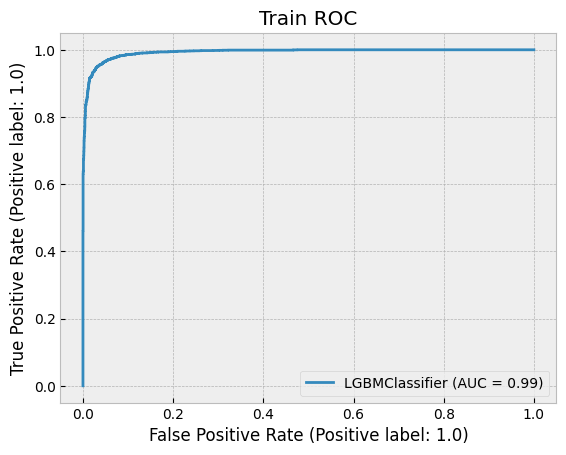

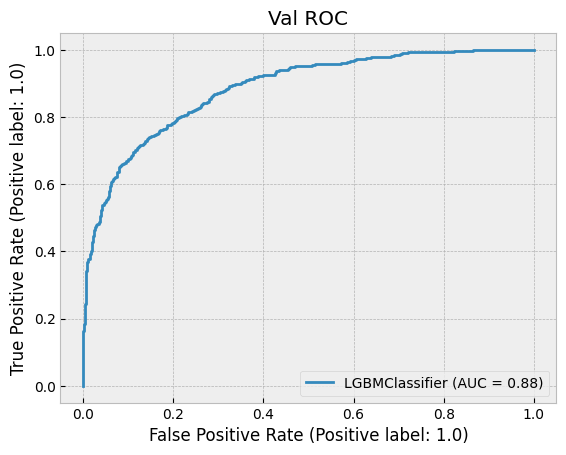

In [19]:
RocCurveDisplay.from_estimator(model, X_train, y_train)
plt.title('Train ROC')
plt.show()
RocCurveDisplay.from_estimator(model, X_val, y_val)
plt.title('Val ROC')
plt.show()